In [1]:
from ema import read, plotting

%load_ext autoreload
%autoreload 2

In [2]:
meal_info = read.all_meal_info()

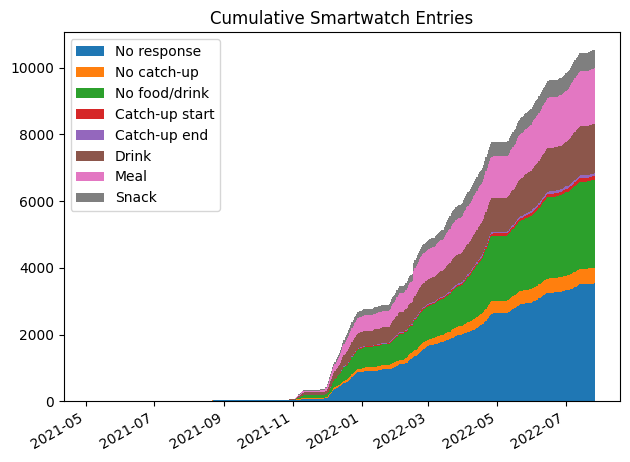

In [3]:
"""
Plot a cumulative histogram showing the number of each type of meal

"""
import pandas as pd
import matplotlib.pyplot as plt


fig, axis = plotting.entry_time_hist(meal_info, cumulative=True)

axis.set_title("Cumulative Smartwatch Entries")
fig.savefig("img/smartwatch_entries_all.png")

### Data cleaning - remove entries with start dates before the watch collection date
Remove entries where the date is before the watch collection date
(in `SEACO data/Stata Datasets/SEACO-CH20 smartwatch feasibility- for LJ.dta`).

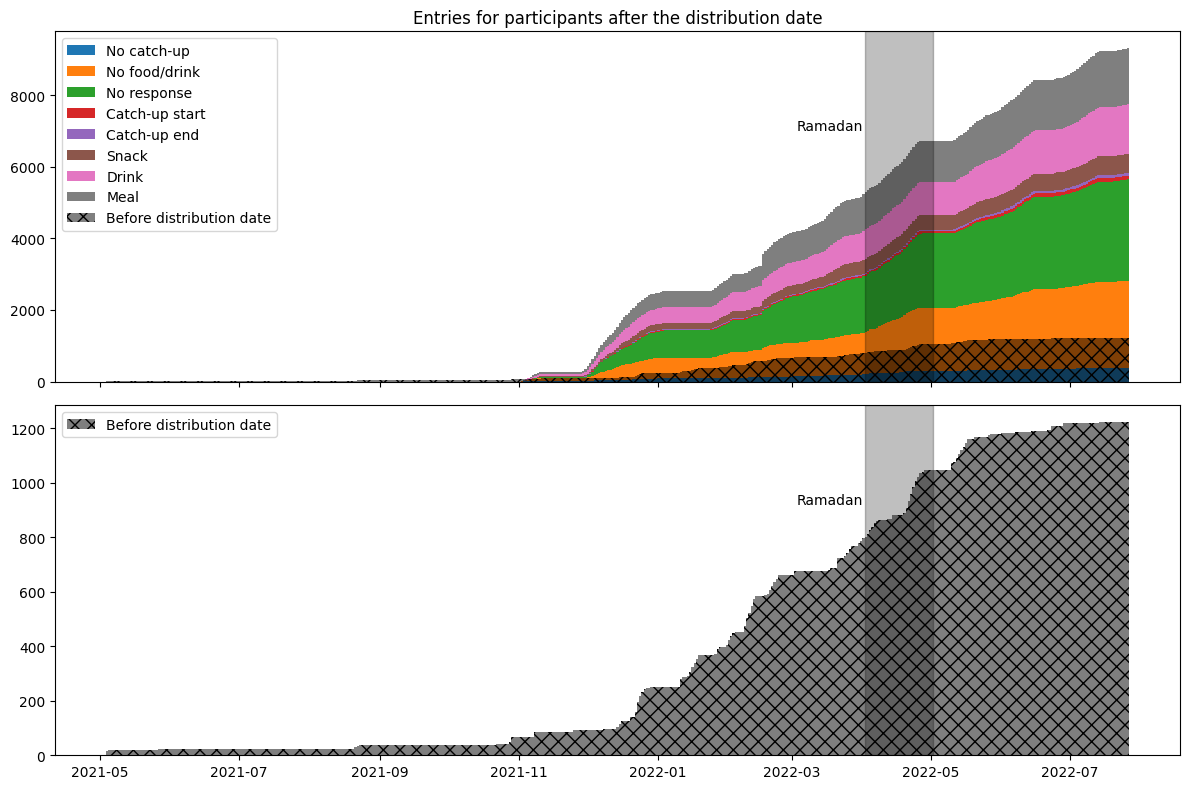

In [4]:
"""
Remove the entries before the watch collection date - these are probably meaningless

"""
# Re read the df to avoid issues with re-running the cell
meal_info = read.all_meal_info()

# Find collection dates for each participant
feasibility_info = read.smartwatch_feasibility()

# We only care about ones who consented to the smartwatch study
feasibility_info = feasibility_info[feasibility_info["smartwatchwilling"] == 1]
feasibility_info = feasibility_info[["residents_id", "actualdateofdistribution1st"]]

# Join dataframes
meal_info = (
    meal_info.reset_index()
    .merge(feasibility_info, left_on="p_id", right_on="residents_id", how="left")
    .set_index(meal_info.index)
)

assert (
    meal_info["actualdateofdistribution1st"].isna().sum() == 0
), "Missing distribution dates"

# Remove entries before the collection date
# TODO - compare only the date; we want to throw away entries from before the collection date
keep = meal_info.index > meal_info["actualdateofdistribution1st"]

# Plot histogram of entries with no collection date
bins = pd.date_range(meal_info.index[0], meal_info.index[-1], freq="1D")

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12, 8))
plotting.entry_time_hist(
    meal_info[keep],
    cumulative=True,
    granularity=bins,
    fig_ax=(fig, axes[0]),
)

# Plot a faded out histogram of entries that are before the collection date
for axis in axes:
    axis.hist(
        meal_info.index[~keep],
        cumulative=True,
        color="k",
        bins=bins,
        alpha=0.5,
        label="Before distribution date",
        hatch="\\\\//",
    )

    axis.legend()

    ymax = axis.get_ylim()[1]
    ramadan_dates = read.ramadan_2022()
    axis.autoscale(enable=False, tight=True)
    axis.fill_between(ramadan_dates, [0, 0], [ymax, ymax], color="k", alpha=0.25)

    axis.text(
        ramadan_dates[0] - pd.Timedelta(days=1),
        0.75 * ymax,
        "Ramadan",
        ha="right",
        va="top",
        color="k",
    )

axes[0].set_title("Entries for participants after the distribution date")
fig.tight_layout()
fig.savefig("img/smartwatch_entries_by_distribution.png")

We can also look at how many days before the distribution date these entries occurred

[-150.0, -148.98305084745763, -147.96610169491527, -146.94915254237287, -145.9322033898305, -144.91525423728814, -143.89830508474577, -142.8813559322034, -141.864406779661, -140.84745762711864, -139.83050847457628, -138.8135593220339, -137.79661016949152, -136.77966101694915, -135.76271186440678, -134.74576271186442, -133.72881355932202, -132.71186440677965, -131.6949152542373, -130.67796610169492, -129.66101694915255, -128.64406779661016, -127.62711864406779, -126.61016949152543, -125.59322033898306, -124.57627118644068, -123.5593220338983, -122.54237288135593, -121.52542372881356, -120.50847457627118, -119.49152542372882, -118.47457627118644, -117.45762711864407, -116.4406779661017, -115.42372881355932, -114.40677966101694, -113.38983050847457, -112.37288135593221, -111.35593220338984, -110.33898305084746, -109.32203389830508, -108.30508474576271, -107.28813559322035, -106.27118644067797, -105.2542372881356, -104.23728813559322, -103.22033898305085, -102.20338983050848, -101.18644067

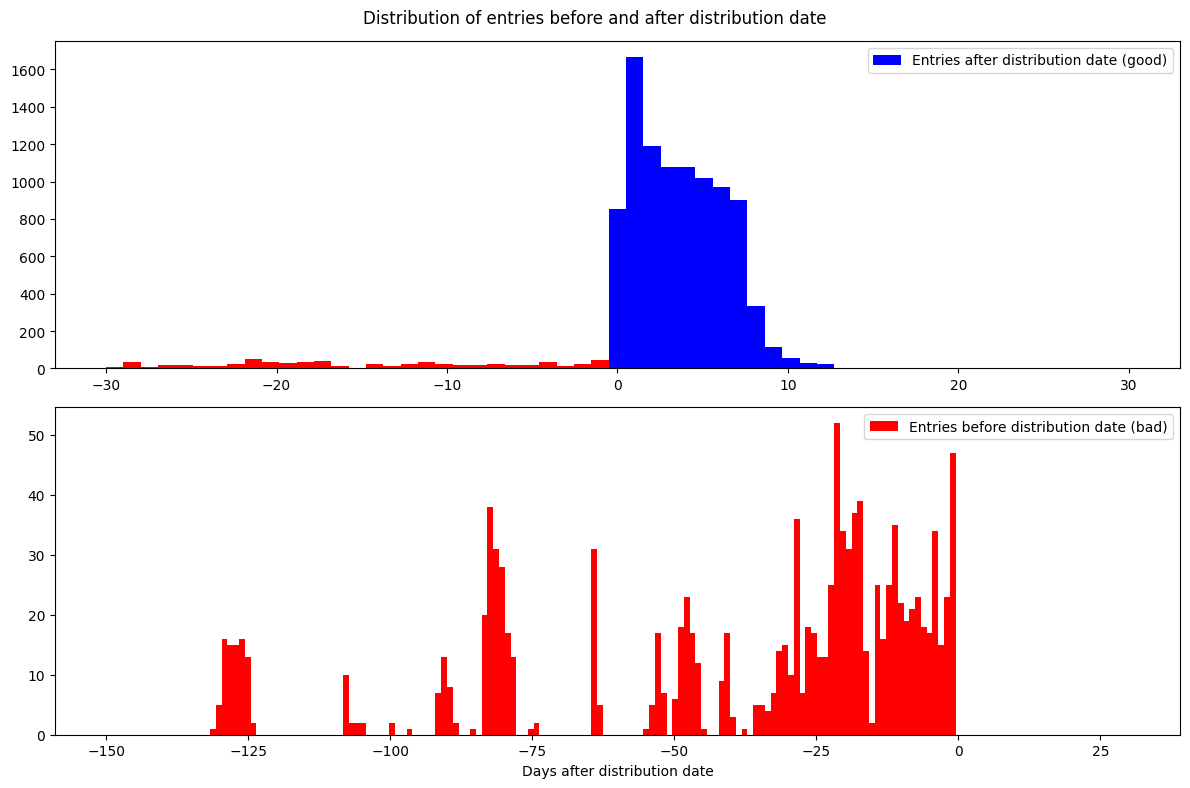

In [5]:
"""
Plot how many days before the distribution date that the bad entries were, then remove them from the dataframe

"""
import numpy as np

# Add a column for how many days after the distribution date the entry was
meal_info["delta"] = (
    meal_info.index.to_series() - meal_info["actualdateofdistribution1st"]
)

# Plot a histogram of this
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

bins = np.linspace(-30, 30, 60)
days = meal_info["delta"].dt.days

axes[0].hist(days, bins=bins, color="r")
axes[0].hist(
    days[days >= 0],
    bins=bins,
    color="b",
    label="Entries after distribution date (good)",
)

bins = sorted(set(np.concatenate([(bins - 120), (bins - 60), bins])))
print(bins)
axes[1].hist(
    days[days < 0], bins=bins, color="r", label="Entries before distribution date (bad)"
)

for axis in axes:
    axis.legend()
axes[1].set_xlabel("Days after distribution date")

fig.suptitle("Distribution of entries before and after distribution date")

fig.tight_layout()
fig.savefig("img/days_after_distribution.png")


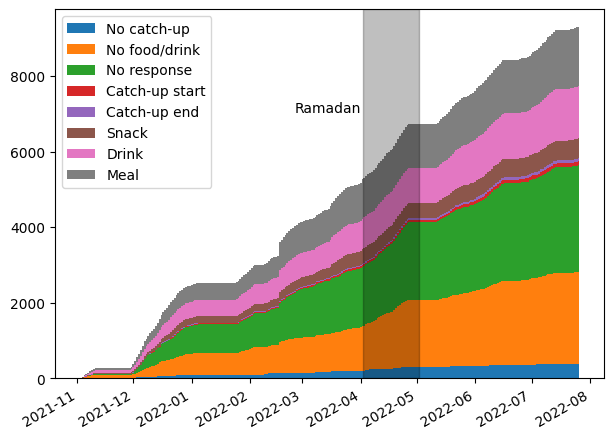

In [6]:
"""
Remove the bad entries and plot histograms again

"""
meal_info = meal_info[meal_info["delta"].dt.days >= 0]

fig, axis = plotting.entry_time_hist(
    meal_info,
    cumulative=True,
    granularity="1D",
)

ymax = axis.get_ylim()[1]
axis.text(
    ramadan_dates[0] - pd.Timedelta(days=1),
    0.75 * ymax,
    "Ramadan",
    ha="right",
    va="top",
    color="k",
)
axis.fill_between(ramadan_dates, [0, 0], [ymax, ymax], color="k", alpha=0.25)
axis.set_ylim(0, ymax)

axes[0].set_title("Entries for participants after the distribution date")
fig.savefig("img/smartwatch_entries_after_distribution.png")

### Sanity check
We want to make sure that each participant is entering the same number of entries per day - if they're being asked once per hour then this should presumably add up to 24.

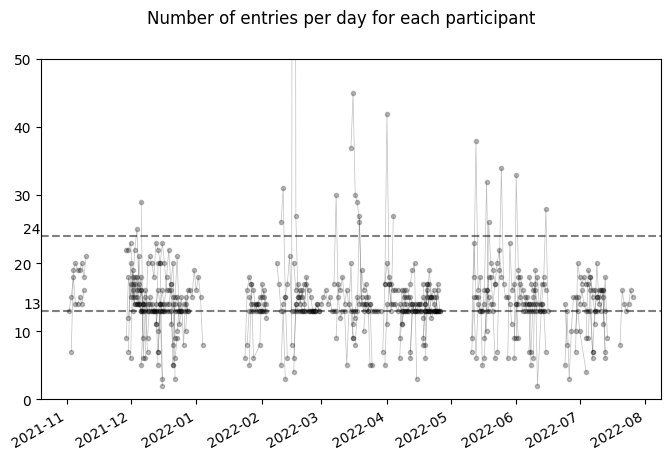

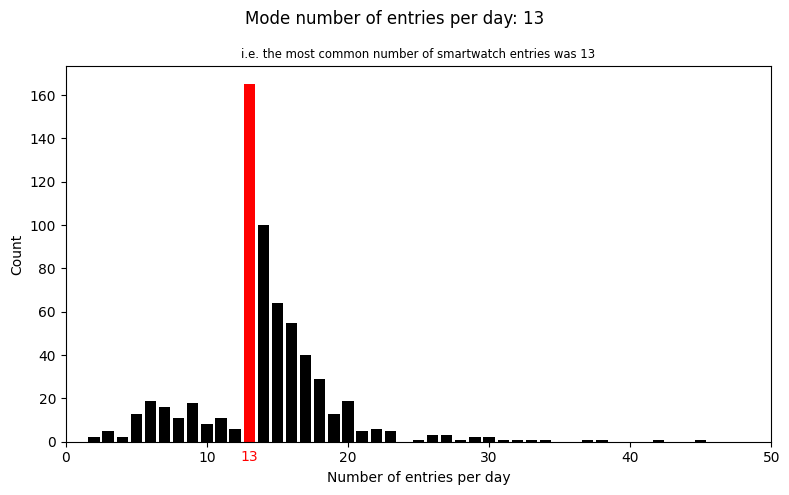

In [7]:
"""
For each participant, find how many entries there were on each day

"""
fig, axis, participant_entries = plotting.participant_entries_per_day(meal_info)

# Indicate some numbers
for number in 13, 24:
    axis.axhline(number, color="k", alpha=0.5, linestyle="--")
    axis.text(meal_info.index[0] - pd.Timedelta(days=22), number, number, va="bottom")

axis.set_ylim(0, 50)
fig.autofmt_xdate()
fig.suptitle("Number of entries per day for each participant")

fig.savefig("img/smartwatch_entries_per_day.png")

# Flatten the array
fig, axis, mode = plotting.participant_entries_histogram(meal_info)
fig.suptitle(f"Mode number of entries per day: {mode}")
axis.set_title(f"i.e. the most common number of smartwatch entries was {mode}", fontsize="small")

fig.tight_layout()
fig.savefig("img/n_entries_per_day.png")

There's some occurrences where lots of entries get recorded on the same date - these are largely duplicates. We can try to remove them...

In [8]:
"""
Remove duplicates

"""
from ema import clean

duplicates = clean.duplicates(meal_info)
print(f"found {duplicates.sum()} duplicates of {len(meal_info)} entries")

total_per_participant = {}
duplicates_per_participant = {}
for participant in meal_info["p_id"].unique():
    this_participant = meal_info["p_id"] == participant

    total_per_participant[participant] = np.sum(this_participant)
    duplicates_per_participant[participant] = np.sum(duplicates[this_participant])

meal_info = meal_info.loc[~duplicates]

found 533 duplicates of 9316 entries


{1195: 255, 8502: 24, 25819: 22, 39184: 19, 19983: 16, 28788: 16, 35272: 13, 24534: 12, 18789: 11, 25527: 11, 26190: 9, 13123: 9, 20050: 8, 28403: 8, 3383: 7, 9891: 7, 27330: 6, 18604: 5, 4219: 5, 1103: 5, 26041: 5, 26912: 5, 24563: 5, 3017: 4, 9359: 4, 26045: 3, 25279: 3, 37497: 3, 20029: 2, 2863: 2, 17582: 2, 141: 2, 8674: 2, 39469: 2, 12961: 2, 36593: 2, 13867: 2, 39055: 2, 17797: 1, 15439: 1, 1339: 1, 26273: 1, 15853: 1, 24973: 1, 23956: 1, 638: 1, 30883: 1, 29061: 1, 33395: 1, 35265: 1, 13197: 1, 16231: 0, 23158: 0, 16401: 0, 15402: 0, 23210: 0, 22904: 0, 17853: 0, 21128: 0, 4260: 0, 16530: 0, 2103: 0, 1361: 0, 4941: 0, 10097: 0, 3171: 0, 23532: 0, 10214: 0, 1097: 0, 1077: 0, 16474: 0, 22470: 0, 39930: 0, 765: 0, 15082: 0, 30407: 0, 8158: 0, 31148: 0, 33734: 0, 27345: 0, 33583: 0, 924: 0, 13439: 0}


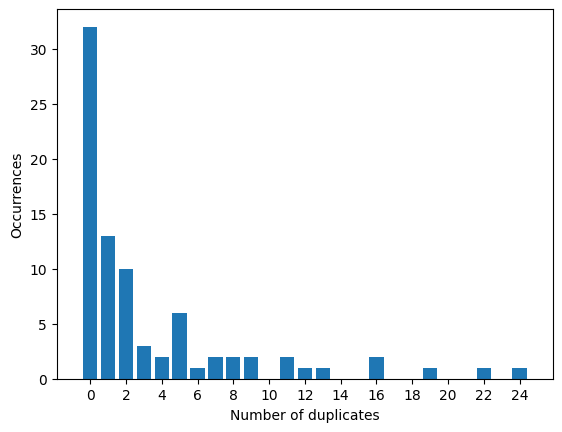

In [9]:
"""
Find how many duplicates each participant had

"""
print(
    {
        k: v
        for k, v in sorted(
            duplicates_per_participant.items(), key=lambda item: -item[1]
        )
    }
)

bins = np.linspace(0, 25, 26) - 0.5
bins = np.concatenate((bins, bins - 0.1, bins + 0.1))
bins.sort()
plt.hist(duplicates_per_participant.values(), bins=bins)
plt.xlabel("Number of duplicates")
plt.ylabel("Occurrences")
plt.xticks(range(25)[::2])
plt.savefig("img/duplicates_hist.png")

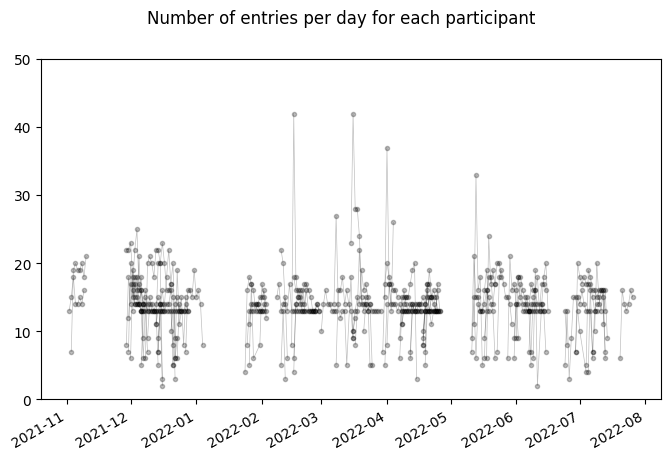

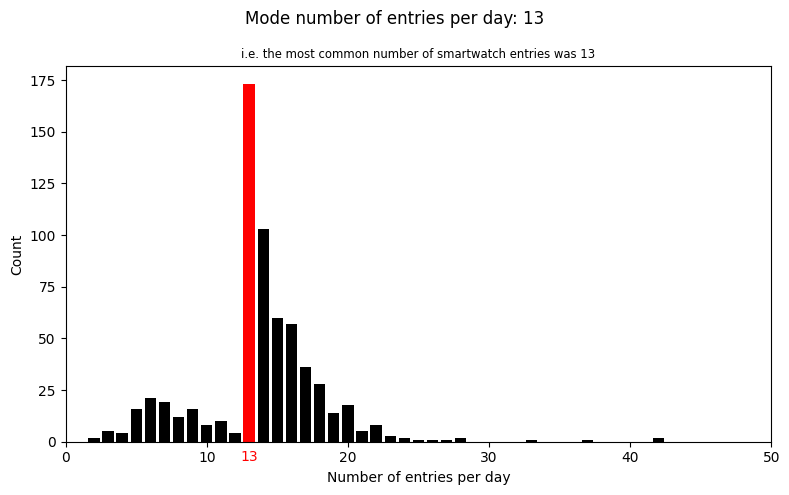

In [10]:
"""
For each participant, find how many entries there were on each day

"""
# Plot lines showing number of entries per day
fig, axis, participant_entries = plotting.participant_entries_per_day(meal_info)

axis.set_ylim(0, 50)
fig.autofmt_xdate()
fig.suptitle("Number of entries per day for each participant")

fig.savefig("img/smartwatch_entries_per_day_no_dups.png")

# Plot bar chart
fig, axis, mode = plotting.participant_entries_histogram(meal_info)
fig.suptitle(f"Mode number of entries per day: {mode}")
axis.set_title(
    f"i.e. the most common number of smartwatch entries was {mode}", fontsize="small"
)

fig.tight_layout()
fig.savefig("img/n_entries_per_day_no_dups.png")

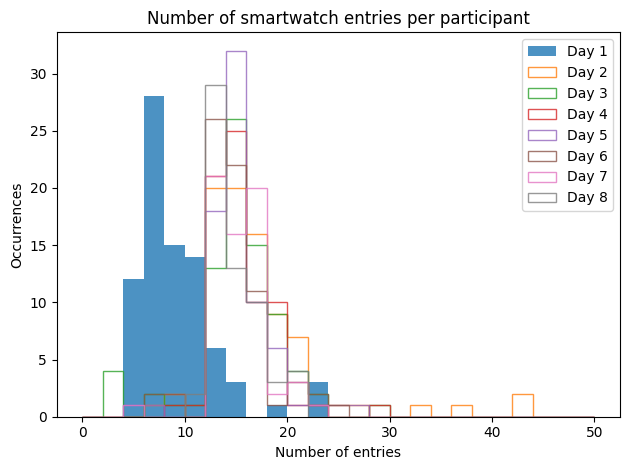

In [11]:
"""
Find how many entries there were on the first day, and then on all subsequent days

"""
participants = meal_info["p_id"].unique()
hist_kw = {"alpha": 0.8, "bins": np.linspace(0, 50, 26)}

for i in range(8):
    # Grab the entries on this day
    mask = (meal_info["delta"] > pd.Timedelta(days=i)) & (
        meal_info["delta"] < pd.Timedelta(days=i + 1)
    )
    df_slice = meal_info[mask]

    # Find how many entries each participant had on this day
    _, counts = np.unique(df_slice["p_id"], return_counts=True)

    plt.hist(
        counts,
        label=f"Day {i+1}",
        **hist_kw,
        histtype="stepfilled" if not i else "step",
    )

plt.legend()
plt.title("Number of smartwatch entries per participant")
plt.xlabel("Number of entries")
plt.ylabel("Occurrences")

plt.tight_layout()
plt.savefig("img/n_entries_per_participant.png")

Day 1: 720 entries removed of 8783


/tmp/ipykernel_20996/4206203556.py:15: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


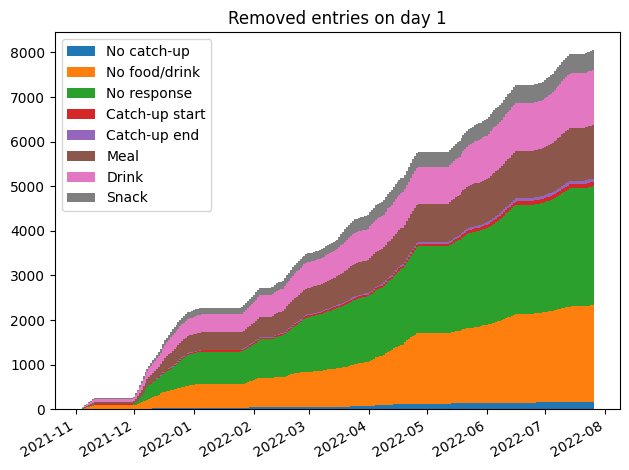

In [12]:
"""
Remove the first day from the meal_info df

"""
keep = meal_info["delta"] > pd.Timedelta(days=1)
print(f"Day 1: {np.sum(~keep)} entries removed of {len(meal_info)}")

meal_info = meal_info[keep]  
fig, axis = plotting.entry_time_hist(
    meal_info,
    cumulative=True,
    granularity="1D",
)
axis.set_title("Removed entries on day 1")
fig.tight_layout()

fig.savefig("img/smartwatch_entries_day_1_removed.png")

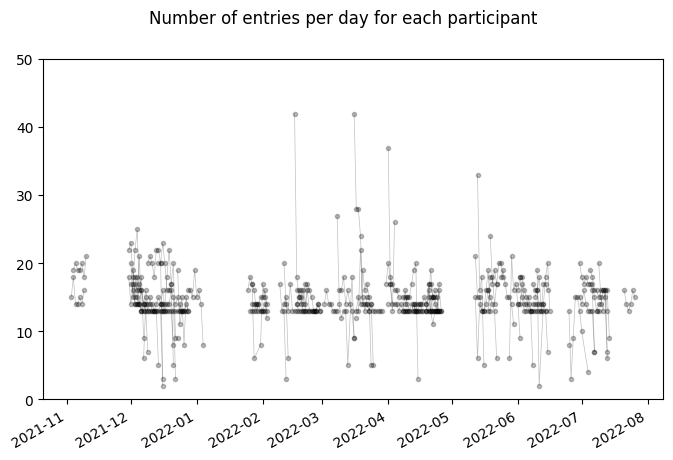

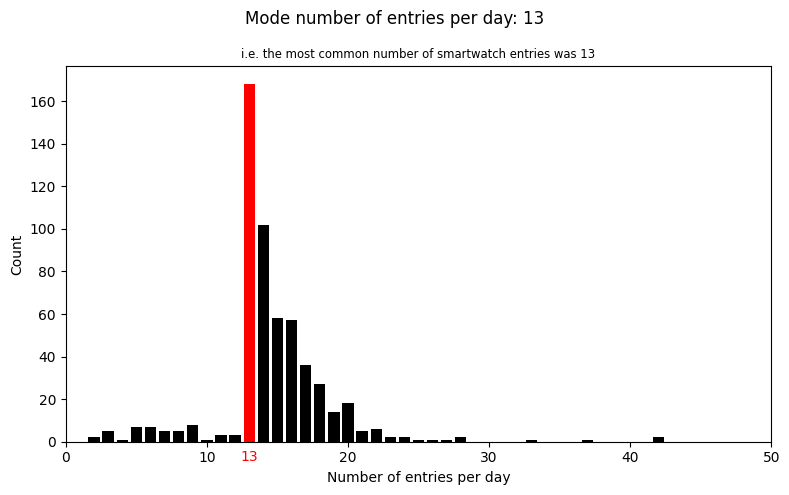

In [13]:
"""
For each participant, find how many entries there were on each day

"""
# Plot lines showing number of entries per day
fig, axis, participant_entries = plotting.participant_entries_per_day(meal_info)

axis.set_ylim(0, 50)
fig.autofmt_xdate()
fig.suptitle("Number of entries per day for each participant")
fig.savefig("img/smartwatch_entries_per_day_no_day1.png")

# Plot bar chart
fig, axis, mode = plotting.participant_entries_histogram(meal_info)
fig.suptitle(f"Mode number of entries per day: {mode}")
axis.set_title(
    f"i.e. the most common number of smartwatch entries was {mode}", fontsize="small"
)

fig.tight_layout()
fig.savefig("img/n_entries_per_day_no_day1.png")